  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 no

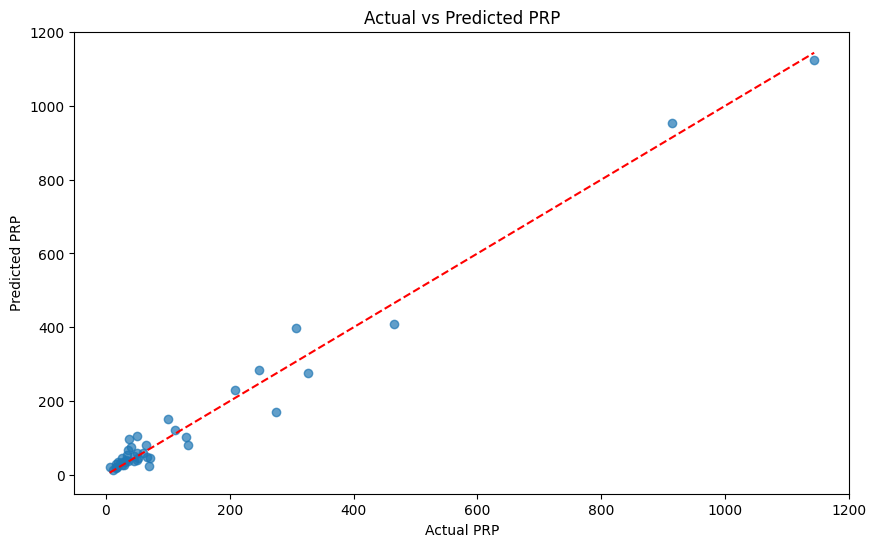

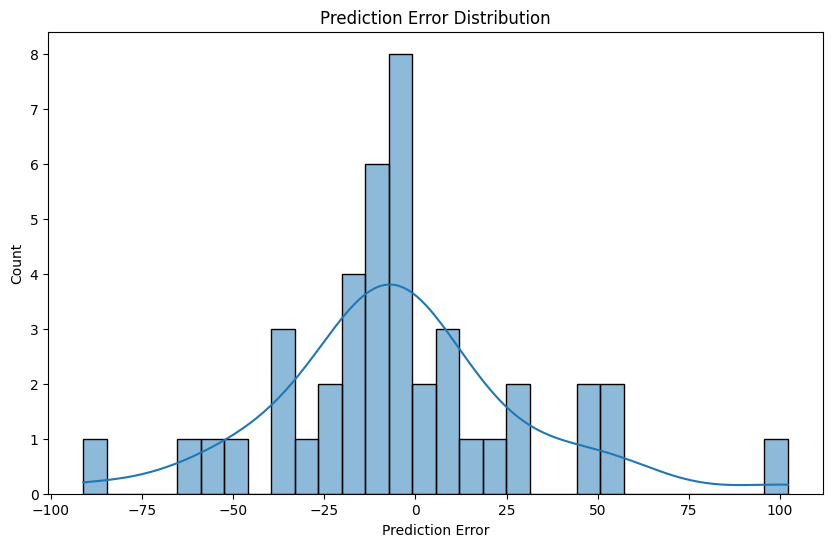

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor

# 1. 데이터 로드
data = pd.read_csv('machine.data_update.csv')

# 데이터 확인
print(data.head())
print(data.info())
print(data.describe())

# 문자열 변수 확인
print(data.select_dtypes(include=['object']).head())

# 3. 데이터 전처리
# 문자열 변수 제거
data = data.select_dtypes(exclude=['object'])

# 특징과 타겟 변수 분리
X = data.drop(columns=['PRP'])
y = data['PRP']

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 파이프라인 구성 및 하이퍼파라미터 튜닝
# 모델 및 파라미터 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", -grid_search.best_score_)

# 5. 앙상블 학습
voting_regressor = VotingRegressor([
    ('lr', LinearRegression()),
    ('ridge', Ridge(alpha=grid_search.best_params_['regressor__alpha'])),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 6. 교차 검증
scores = cross_val_score(voting_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation MSE:", -scores.mean())

# 모델 훈련
voting_regressor.fit(X_train, y_train)

# 7. 예측 및 성능 평가
y_pred = voting_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# 8. 결과 시각화
# 실제값과 예측값 비교
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual PRP")
plt.ylabel("Predicted PRP")
plt.title("Actual vs Predicted PRP")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

# 예측 오차 시각화
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred, kde=True, bins=30)
plt.xlabel("Prediction Error")
plt.title("Prediction Error Distribution")
plt.show()


In [3]:
from sklearn.metrics import mean_absolute_error

# Best estimator from grid search
best_model = grid_search.best_estimator_

# 1. 학습 데이터에 대한 평가
y_train_pred = best_model.predict(X_train)

train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error: {train_mse}')
print(f'Training Mean Absolute Error: {train_mae}')
print(f'Training R^2 Score: {train_r2}')

# 2. 테스트 데이터에 대한 평가
y_test_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# 3. 교차 검증 평가
cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cross_val_mse = -cross_val_scores.mean()

print(f'Cross-validation Mean Squared Error: {cross_val_mse}')


Training Mean Squared Error: 1529.1018807131193
Training Mean Absolute Error: 23.22293531086101
Training R^2 Score: 0.9204605696912153
Test Mean Squared Error: 2340.6178908842658
Test Mean Absolute Error: 31.296748406990933
Test R^2 Score: 0.9540215561379077
Cross-validation Mean Squared Error: 3371.7918286713116


C:\Users\dbdlr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
400 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dbdlr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dbdlr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dbdlr\AppDa

Best Parameters: {'pca__n_components': 0.95, 'poly__degree': 2, 'regressor__learning_rate': 0.12538077692527183, 'regressor__max_depth': 3, 'regressor__n_estimators': 168, 'regressor__subsample': 0.9301852682415552}
Best CV Score: 4601.247421857324
Training Mean Squared Error: 104.13022800554654
Training Mean Absolute Error: 5.203163343132578
Training R^2 Score: 0.994583448547181
Test Mean Squared Error: 4407.176723573536
Test Mean Absolute Error: 37.06929604016603
Test R^2 Score: 0.913426651840813
Cross-validation Mean Squared Error: 6383.403520309374


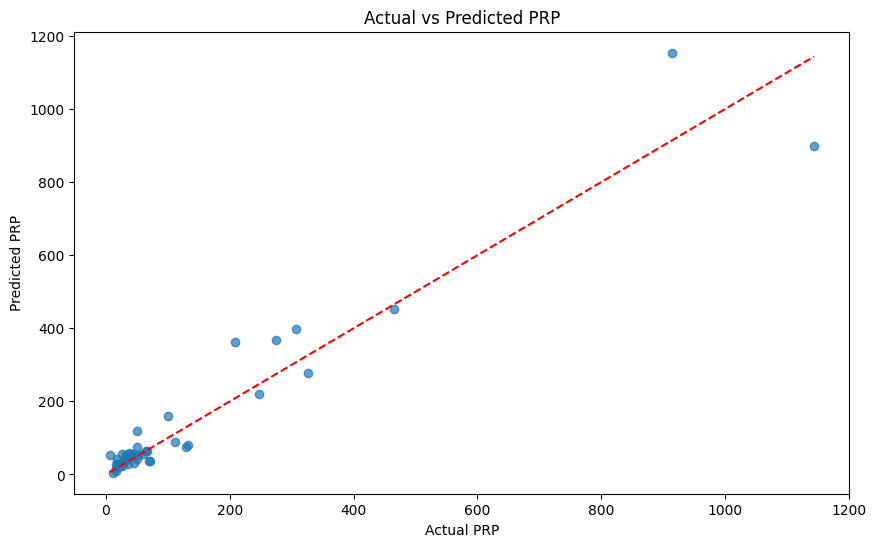

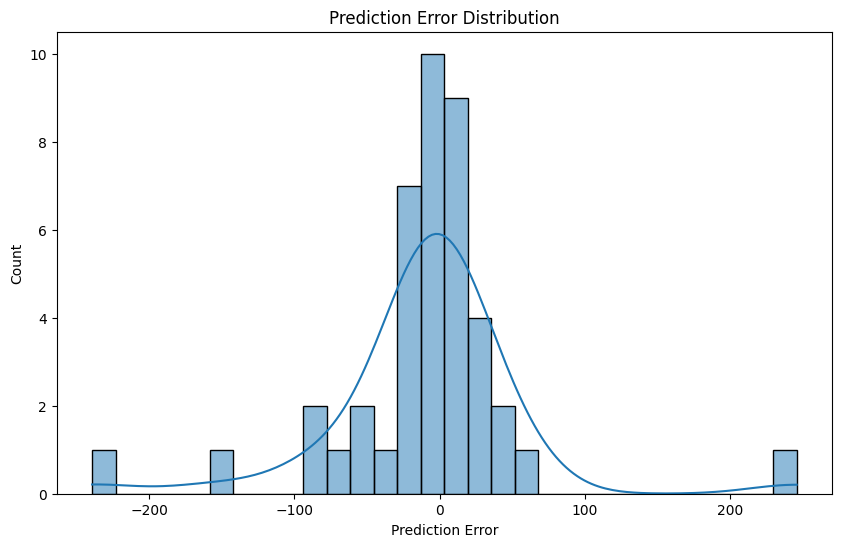

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 1. 데이터 로드 및 탐색 (이전 단계와 동일)
data = pd.read_csv('machine.data_update.csv')

# 문자열 변수 제거
data = data.select_dtypes(exclude=['object'])

# 특징과 타겟 변수 분리
X = data.drop(columns=['PRP'])
y = data['PRP']

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 파이프라인 구성 및 하이퍼파라미터 튜닝
# 모델 및 파라미터 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=0.95)),
    ('regressor', GradientBoostingRegressor())
])

param_dist = {
    'poly__degree': [2, 3],
    'pca__n_components': [0.9, 0.95, 0.99],
    'regressor__n_estimators': randint(100, 200),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__subsample': uniform(0.7, 1.0)
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", -random_search.best_score_)

# Best estimator from random search
best_model = random_search.best_estimator_

# 3. 모델 평가
# 학습 데이터에 대한 평가
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error: {train_mse}')
print(f'Training Mean Absolute Error: {train_mae}')
print(f'Training R^2 Score: {train_r2}')

# 테스트 데이터에 대한 평가
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# 교차 검증 평가
cross_val_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cross_val_mse = -cross_val_scores.mean()

print(f'Cross-validation Mean Squared Error: {cross_val_mse}')

# 4. 결과 시각화 (이전 단계와 동일)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel("Actual PRP")
plt.ylabel("Predicted PRP")
plt.title("Actual vs Predicted PRP")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_test_pred, kde=True, bins=30)
plt.xlabel("Prediction Error")
plt.title("Prediction Error Distribution")
plt.show()


C:\Users\dbdlr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
400 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dbdlr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dbdlr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dbdlr\AppDa

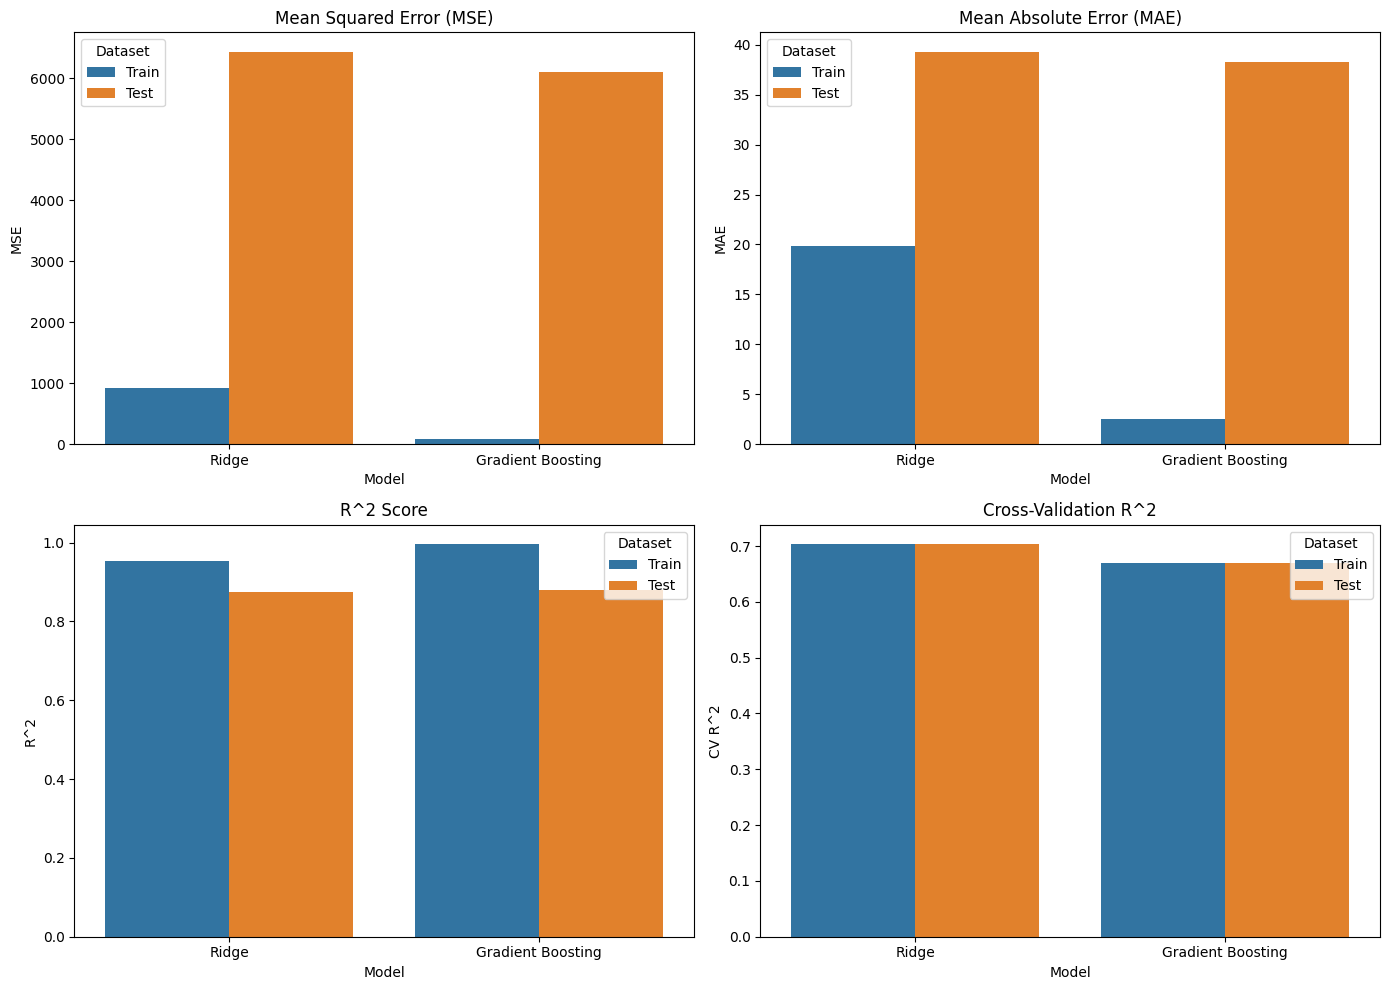

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint

# 데이터 호출
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
names = ['vendor_name', 'model_name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
data = pd.read_csv(url, names=names)

# 필요한 변수 선택
features = ["MYCT", "MMIN", "MMAX", "CACH", "CHMIN", "CHMAX"]
target = "PRP"
X = data[features]
y = data[target]

# 데이터 전처리
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. 첫 번째 모델 (PolynomialFeatures + Ridge)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

ridge = Ridge()
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2')
grid_search_ridge.fit(X_train_poly, y_train)

best_ridge = grid_search_ridge.best_estimator_

# 첫 번째 모델 성능 평가
y_train_pred_ridge = best_ridge.predict(X_train_poly)
y_test_pred_ridge = best_ridge.predict(X_test_poly)

train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
cv_scores_ridge = cross_val_score(best_ridge, X_train_poly, y_train, cv=5, scoring='r2')
cv_r2_ridge = np.mean(cv_scores_ridge)

test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

# 2. 두 번째 모델 (PolynomialFeatures + PCA + GradientBoostingRegressor)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=0.95)),
    ('regressor', GradientBoostingRegressor())
])

param_dist = {
    'poly__degree': [2, 3],
    'pca__n_components': [0.9, 0.95, 0.99],
    'regressor__n_estimators': randint(100, 200),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__subsample': uniform(0.7, 1.0)
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

best_gb = random_search.best_estimator_

# 두 번째 모델 성능 평가
y_train_pred_gb = best_gb.predict(X_train)
y_test_pred_gb = best_gb.predict(X_test)

train_mse_gb = mean_squared_error(y_train, y_train_pred_gb)
train_mae_gb = mean_absolute_error(y_train, y_train_pred_gb)
train_r2_gb = r2_score(y_train, y_train_pred_gb)
cv_scores_gb = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='r2')
cv_r2_gb = np.mean(cv_scores_gb)

test_mse_gb = mean_squared_error(y_test, y_test_pred_gb)
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

# 성능 지표 데이터프레임 생성
results = {
    'Model': ['Ridge', 'Ridge', 'Gradient Boosting', 'Gradient Boosting'],
    'Dataset': ['Train', 'Test', 'Train', 'Test'],
    'MSE': [train_mse_ridge, test_mse_ridge, train_mse_gb, test_mse_gb],
    'MAE': [train_mae_ridge, test_mae_ridge, train_mae_gb, test_mae_gb],
    'R^2': [train_r2_ridge, test_r2_ridge, train_r2_gb, test_r2_gb],
    'CV R^2': [cv_r2_ridge, cv_r2_ridge, cv_r2_gb, cv_r2_gb]
}

results_df = pd.DataFrame(results)

# 성능 결과 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MSE
sns.barplot(x='Model', y='MSE', hue='Dataset', data=results_df, ax=axes[0, 0])
axes[0, 0].set_title('Mean Squared Error (MSE)')

# MAE
sns.barplot(x='Model', y='MAE', hue='Dataset', data=results_df, ax=axes[0, 1])
axes[0, 1].set_title('Mean Absolute Error (MAE)')

# R^2
sns.barplot(x='Model', y='R^2', hue='Dataset', data=results_df, ax=axes[1, 0])
axes[1, 0].set_title('R^2 Score')

# CV R^2
sns.barplot(x='Model', y='CV R^2', hue='Dataset', data=results_df, ax=axes[1, 1])
axes[1, 1].set_title('Cross-Validation R^2')

plt.tight_layout()
plt.show()
